In [1]:
!pip uninstall -y screenpro2
!pip install git+https://github.com/ArcInstitute/screenpro2.git@dev

Found existing installation: ScreenPro2 0.4.0
Uninstalling ScreenPro2-0.4.0:
  Successfully uninstalled ScreenPro2-0.4.0
  Cloning https://github.com/ArcInstitute/screenpro2.git (to revision dev) to /tmp/pip-req-build-gb7tg37a
  Running command git clone --filter=blob:none --quiet https://github.com/ArcInstitute/screenpro2.git /tmp/pip-req-build-gb7tg37a
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
  Resolved https://github.com/ArcInstitute/screenpro2.git to commit 6f0a7a612e458f8346efe288aa2f095788b4a376
  Preparing metadata (setup.py) ... done
  Created wheel for ScreenPro2: filename=ScreenPro2-0.4.0-py3-none-any.whl size=35088 sha256=a1022930e085cc6e22552e92532c4b47c8133b2a924edbae66726303b3ea4d1d
  Stored in directory: /tmp/pip-ephem-wheel-cache-xe2qmvi7/wheels/4c/5b/3b/b0fb7e5295ecc7453394ca2c5680bf423c37c4917767218de0
Successfully built ScreenPro2


In [2]:
import numpy as np
import pandas as pd 
import anndata as ad
import scanpy as sc

import screenpro as scp

import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=150, format='svg', frameon=False, figsize=(3, 3), color_map='RdGy', facecolor='white')

In [ ]:
from glob import glob

In [3]:
from screenpro.plotting import almost_black, dark2

In [4]:
# help(scp.phenoScore.getPhenotypeScore)

# help(scp.pl.plotReplicateScatter)

In [5]:
scp.utils.ann_score_df

<function screenpro.utils.ann_score_df(df_in, up_hit='resistance_hit', down_hit='sensitivity_hit', ctrl_label='control', threshold=10)>

In [226]:
library_table = pd.read_csv(
    'CRISPRi_dual_human_librarytable_corrected_v2.txt', 
    sep = '\t', index_col=False, low_memory=False)

In [214]:
counter = scp.GuideCounter(cas_type = 'cas9', library_type = 'dual_guide_design')

In [215]:
counter.load_library(
    'CRISPRi_dual_human_librarytable_corrected_v2.txt', sep = '\t', index_col=False,
    # 'JR_V3lib_top2_v2.csv', sep = ',', 
    verbose = True
)

/home/abea/miniconda3/envs/screenpro2/lib/python3.9/site-packages/screenpro/load.py:14: DtypeWarning: Columns (7,8,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  library = pd.read_csv(


Trimming protospacer sequences in 'protospacer_A' column.
Trimming protospacer sequences in 'protospacer_B' column.
Library table successfully loaded.
total # of cas9 sgRNAs: 125721


In [220]:
samples = [
    s.split('/')[-1].replace('_R1.fastq.gz','')
    for s in glob('fastq_merged/*R1.fastq.gz')
]
samples.sort()

In [221]:
samples

['i01',
 'i02',
 'i03',
 'i04',
 'i05',
 'i06',
 'i07',
 'i08',
 'i09',
 'i10',
 'i11',
 'i12',
 'i13',
 'i14',
 'i15',
 'i16']

In [222]:
counter.get_counts_matrix(
    fastq_dir = 'fastq_merged',
    samples = samples,
    get_recombinant=True,
    # write='force',
    verbose = True
)

i01
done in 25.581s
count file written ...
% mapped reads 66.34202614968581
% unmapped reads 33.657973850314185
% fully remapped recombination events 26.47737763246664
i02
done in 28.356s
count file written ...
% mapped reads 66.32218193273496
% unmapped reads 33.67781806726504
% fully remapped recombination events 26.50011577061559
i03
done in 43.776s
count file written ...
% mapped reads 67.20907556484951
% unmapped reads 32.79092443515049
% fully remapped recombination events 25.272198653710067
i04
done in 39.586s
count file written ...
% mapped reads 66.92354310294688
% unmapped reads 33.07645689705313
% fully remapped recombination events 25.37066787477768
i05
done in 41.695s
count file written ...
% mapped reads 67.21893941522036
% unmapped reads 32.78106058477964
% fully remapped recombination events 25.303932753452987
i06
done in 32.379s
count file written ...
% mapped reads 67.36169475481583
% unmapped reads 32.63830524518417
% fully remapped recombination events 25.4041324665

In [224]:
counter.counts_mat.sum() / 10**6

i01    24.148331
i02    28.847160
i03    45.664373
i04    41.157890
i05    44.508120
i06    36.048196
i07    40.013010
i08    31.109935
i09    28.506749
i10    26.428348
i11    38.351913
i12    39.298149
i13    85.610964
i14    30.551431
i15    31.217038
i16    35.184928
dtype: float64

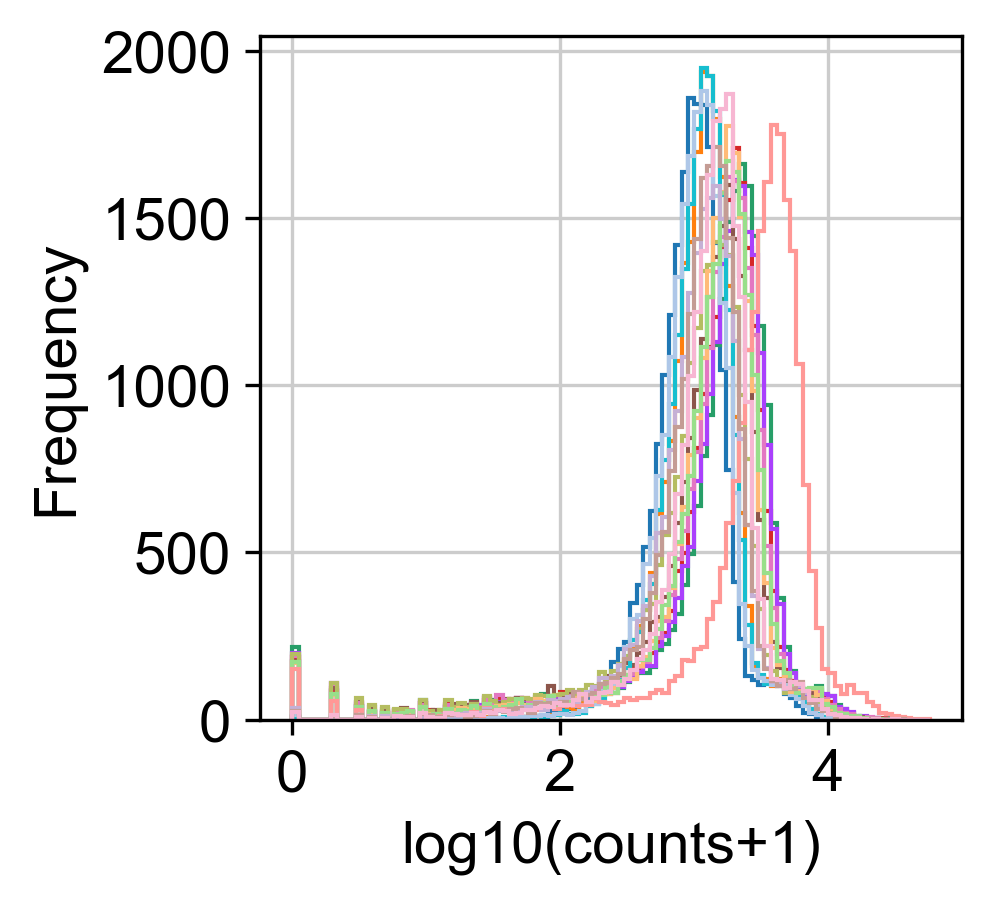

In [234]:
_,ax = plt.subplots()
# plot count distribution
np.log10(
    counter.counts_mat.loc[
    sorted(list(
            set(library_table.query('sublibrary == "h_dual_1"').sgID_AB) & \
            set(counter.counts_mat.index)
        ))
,:]+1
).plot.hist(bins=100, histtype='step', ax=ax)

plt.xlabel('log10(counts+1)')
# plt.legend(loc='upper left')
ax.get_legend().remove()

plt.show()

### load counts and metadata

In [ ]:
# adata = ad.read_h5ad('results/adata_counts.h5ad.gz')
# 
# del adata.layers

In [235]:
meta = pd.read_excel('PRDX1samplesheet_incgrowth.xlsx',index_col=0)

In [317]:
adata = counter.build_counts_anndata()

adata.obs = meta 
adata.obs.treatment = adata.obs.treatment.str.replace('-','T0')
adata.obs = adata.obs.rename(columns={'treatment':'condition','rep':'replicate'})

adata.obs['pop_doublings'] = meta['pop doublings'].replace('-',np.nan).astype(float)

___
<!-- - filter low counts -->

In [318]:
adata0 = adata.copy()

___

In [319]:
scp.pl.plotReplicateScatter

<function screenpro.plotting.plotReplicateScatter(ax, adat_in, x, y, title, min_val=None, max_val=None, log_transform=False, **args)>

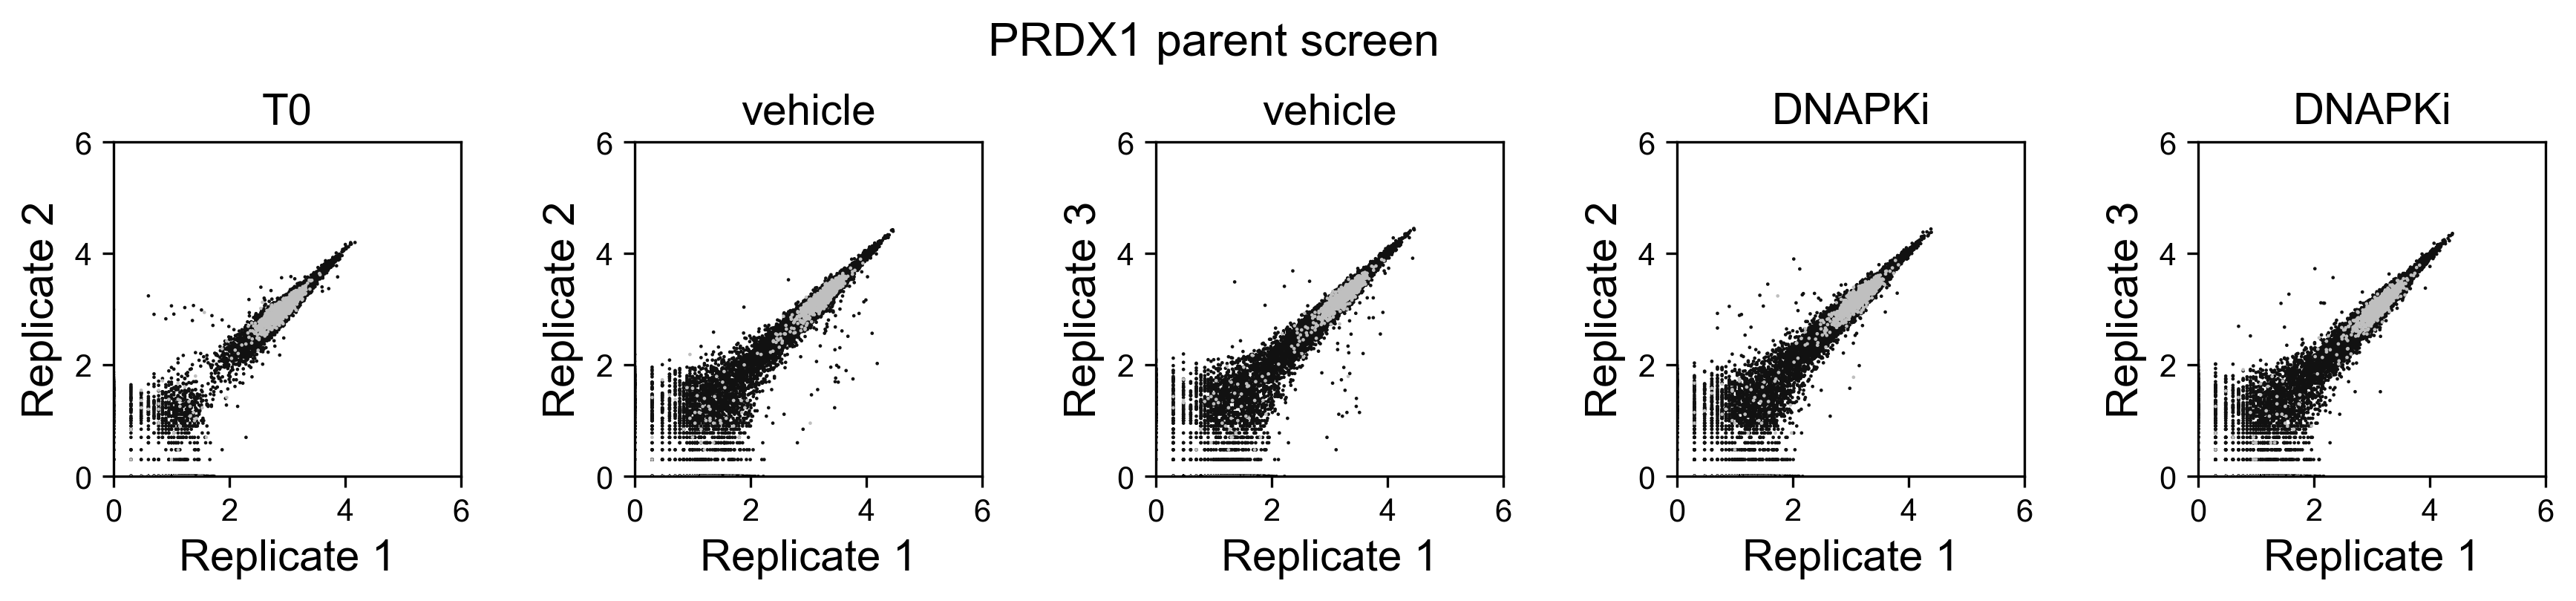

In [320]:
fig, axes = plt.subplots(ncols=5,
                         figsize=(13,3), 
                         gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.8,'bottom':.3}, 
                         # sharey=True
                        )
scp.pl.plotReplicateScatter(axes[0], adata, 'i01','i02','T0',min_val=0,max_val=6, log_transform=True)
scp.pl.plotReplicateScatter(axes[1], adata, 'i03','i04','vehicle',min_val=0,max_val=6, log_transform=True)
scp.pl.plotReplicateScatter(axes[2], adata, 'i03','i05','vehicle',min_val=0,max_val=6, log_transform=True)
scp.pl.plotReplicateScatter(axes[3], adata, 'i06','i07','DNAPKi',min_val=0,max_val=6, log_transform=True)
scp.pl.plotReplicateScatter(axes[4], adata, 'i06','i08','DNAPKi',min_val=0,max_val=6, log_transform=True)

fig.suptitle('PRDX1 parent screen',fontsize=15)

plt.show()

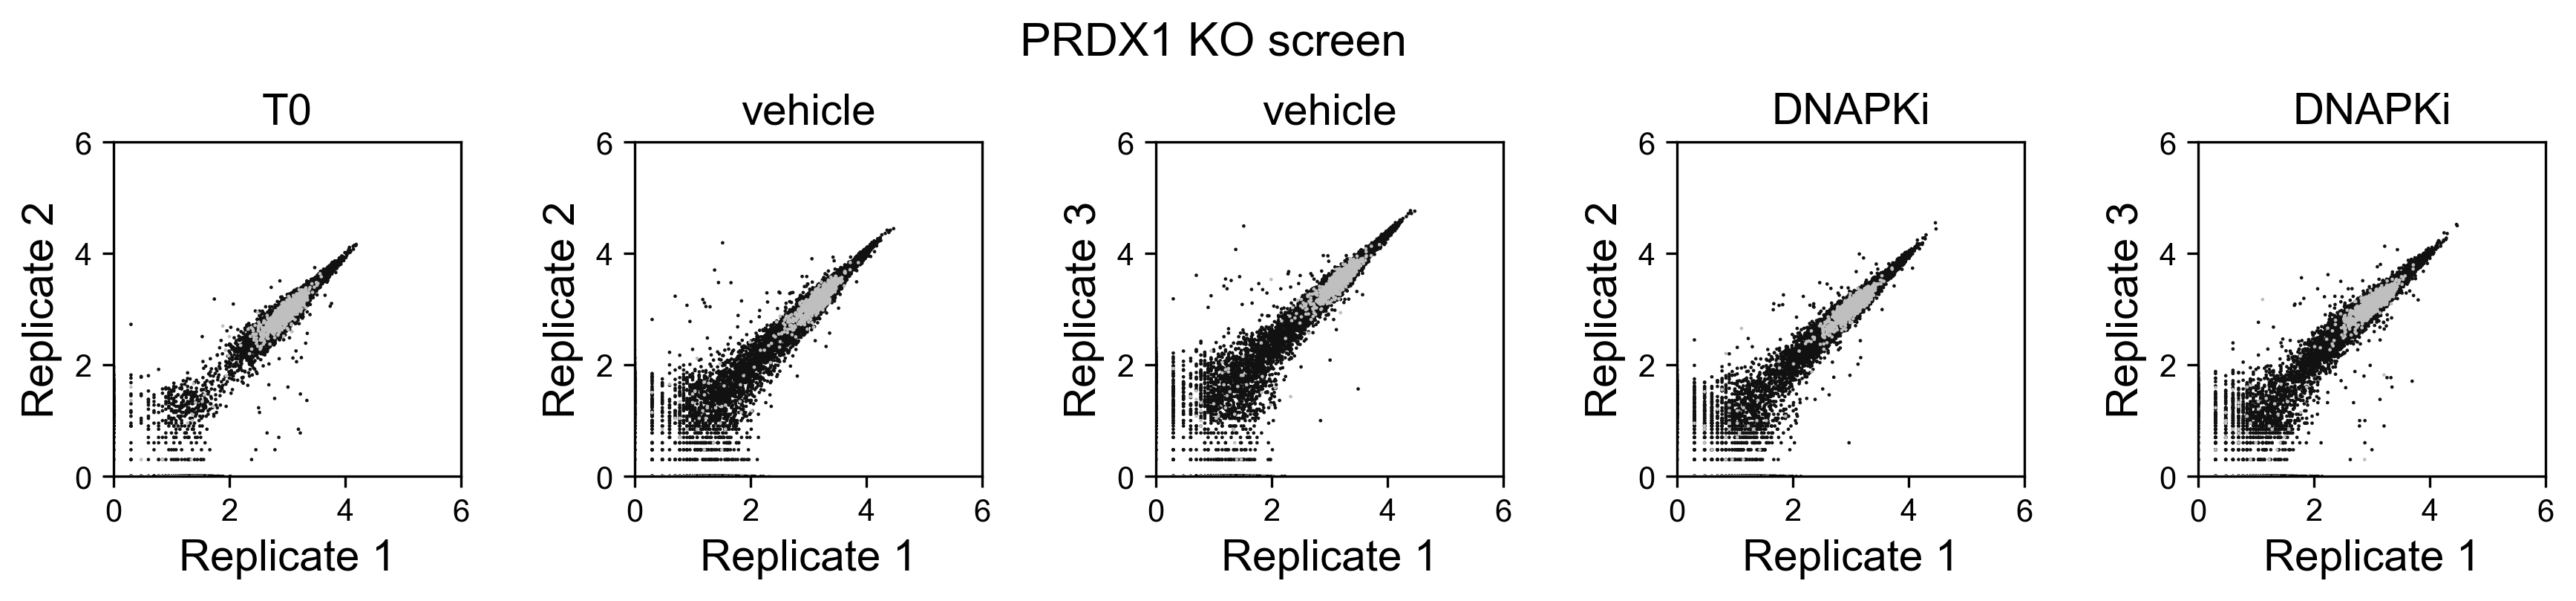

In [321]:
fig, axes = plt.subplots(ncols=5,
                         figsize=(13,3), 
                         gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.8,'bottom':.3}, 
                         # sharey=True
                        )
scp.pl.plotReplicateScatter(axes[0], adata, 'i09','i10','T0',min_val=0,max_val=6, log_transform=True)
scp.pl.plotReplicateScatter(axes[1], adata, 'i11','i12','vehicle',min_val=0,max_val=6, log_transform=True)
scp.pl.plotReplicateScatter(axes[2], adata, 'i11','i13','vehicle',min_val=0,max_val=6, log_transform=True)
scp.pl.plotReplicateScatter(axes[3], adata, 'i14','i15','DNAPKi',min_val=0,max_val=6, log_transform=True)
scp.pl.plotReplicateScatter(axes[4], adata, 'i14','i16','DNAPKi',min_val=0,max_val=6, log_transform=True)

fig.suptitle('PRDX1 KO screen',fontsize=15)

plt.show()

#### Add 3rd pseudoreplicate for T0

In [322]:
# add a 3rd replicate to the parent data as average of the two existing replicates
def add_pseudoreplicate(adata,index_rep1,index_rep2, name_new_replicate=3):
    adata = adata.copy()
    # name index ad pseudoreplicate
    index_pseudorep = f'{index_rep1}_{index_rep2}'
    
    if index_pseudorep in adata.obs.index:
        raise ValueError(f'Pseudoreplicate {index_pseudorep} already exists in the AnnData object.')

    # create a new AnnData object
    adata_pseudorep = ad.AnnData(pd.Series(
        adata[adata.obs.index.isin([index_rep1,index_rep2])].X.mean(axis=0),
        index=adata.var.index,
        name=index_pseudorep
    ).astype(int).to_frame().T)
    # update the metadata
    adata_pseudorep.obs['replicate'] = name_new_replicate
    for key in adata.obs.columns:
        if key not in adata_pseudorep.obs.columns:
            adata_pseudorep.obs[key] = adata.obs[key].loc[index_rep1]

    # add the pseudoreplicate to the original AnnData object
    out = ad.concat([adata, adata_pseudorep])
    out.var = adata.var.copy()

    return out

In [323]:
adata = add_pseudoreplicate(adata,'i01','i02')

In [324]:
adata = add_pseudoreplicate(adata,'i09','i10')

In [325]:
adata.obs

,cell line,timepoint,condition,replicate,pop doublings,pop_doublings
i01,parent,T0,T0,1,-,NaN
i02,parent,T0,T0,2,-,NaN
i03,parent,Tend,vehicle,1,8.099107,8.099107
i04,parent,Tend,vehicle,2,7.760087,7.760087
i05,parent,Tend,vehicle,3,7.799925,7.799925
i06,parent,Tend,DNAPKi,1,7.459794,7.459794
i07,parent,Tend,DNAPKi,2,7.541174,7.541174
i08,parent,Tend,DNAPKi,3,7.709747,7.709747
i09,PRDX1KO,T0,T0,1,-,NaN
i10,PRDX1KO,T0,T0,2,-,NaN


### scores

    'PRDX1_parent gamma vehicle_vs_T0',
    'PRDX1_parent rho DNAPKi_vs_vehicle',
    'PRDX1_parent tau DNAPKi_vs_T0',

    'PRDX1_KO gamma vehicle_vs_T0',
    'PRDX1_KO rho DNAPKi_vs_vehicle',
    'PRDX1_KO tau DNAPKi_vs_T0',
<!--     'rho vehicle_PRDX1KO_vs_vehicle_parent' -->

___

In [326]:
adata_PRDX1KO = adata[adata.obs['cell line'].eq('PRDX1KO')].copy()
adata_parent  = adata[adata.obs['cell line'].eq('parent')].copy()

### PRDX1 parent screen

In [327]:
screen = scp.PooledScreens(adata_parent)

In [328]:
scp.utils.find_low_counts(screen.adata)

screen.adata = screen.adata[:,~screen.adata.var.low_count].copy()

44418 variables with less than 50 reads (filter_type: 'either')


In [329]:
screen.countNormalization()

___

In [331]:
screen.calculateDrugScreen(
    t0='T0', untreated='vehicle', treated='DNAPKi',
    db_untreated = 7.8,
    db_treated = 7.5,
    score_level='compare_reps'
)

	vehicle vs T0
	DNAPKi vs T0
	DNAPKi vs vehicle


In [333]:
sel = ['target','score','ttest pvalue']# BH adj_pvalue # ttest pvalue

In [334]:
gamma = screen.phenotypes['compare_reps']['gamma:vehicle_vs_T0'].loc[:,sel].reset_index(drop=True)

tau = screen.phenotypes['compare_reps']['tau:DNAPKi_vs_T0'].loc[:,sel].reset_index(drop=True)

rho = screen.phenotypes['compare_reps']['rho:DNAPKi_vs_vehicle'].loc[:,sel].reset_index(drop=True)

In [335]:
gamma.score.min(),gamma.score.max(), max(-np.log10(gamma['ttest pvalue']))

(-0.7893476734697443, 0.27363584861020285, 5.575685753456394)

In [336]:
tau.score.min(),tau.score.max(),max(-np.log10(tau['ttest pvalue']))

(-0.8357253136596348, 0.4816305460435467, 7.406412133679788)

In [337]:
rho.score.min(),rho.score.max(),max(-np.log10(rho['ttest pvalue']))

(-11.148856901452389, 8.33576555470878, 4.5620961653900185)

#### replicate level scores

AnnData object with n_obs × n_vars = 9 × 19819
    obs: 'score', 'growth_factor', 'replicate'
    var: 'sgID_A', 'sgID_B', 'target_A', 'protospacer_A', 'target_B', 'protospacer_B', 'targetType', 'target', 'sequence', 'low_count'

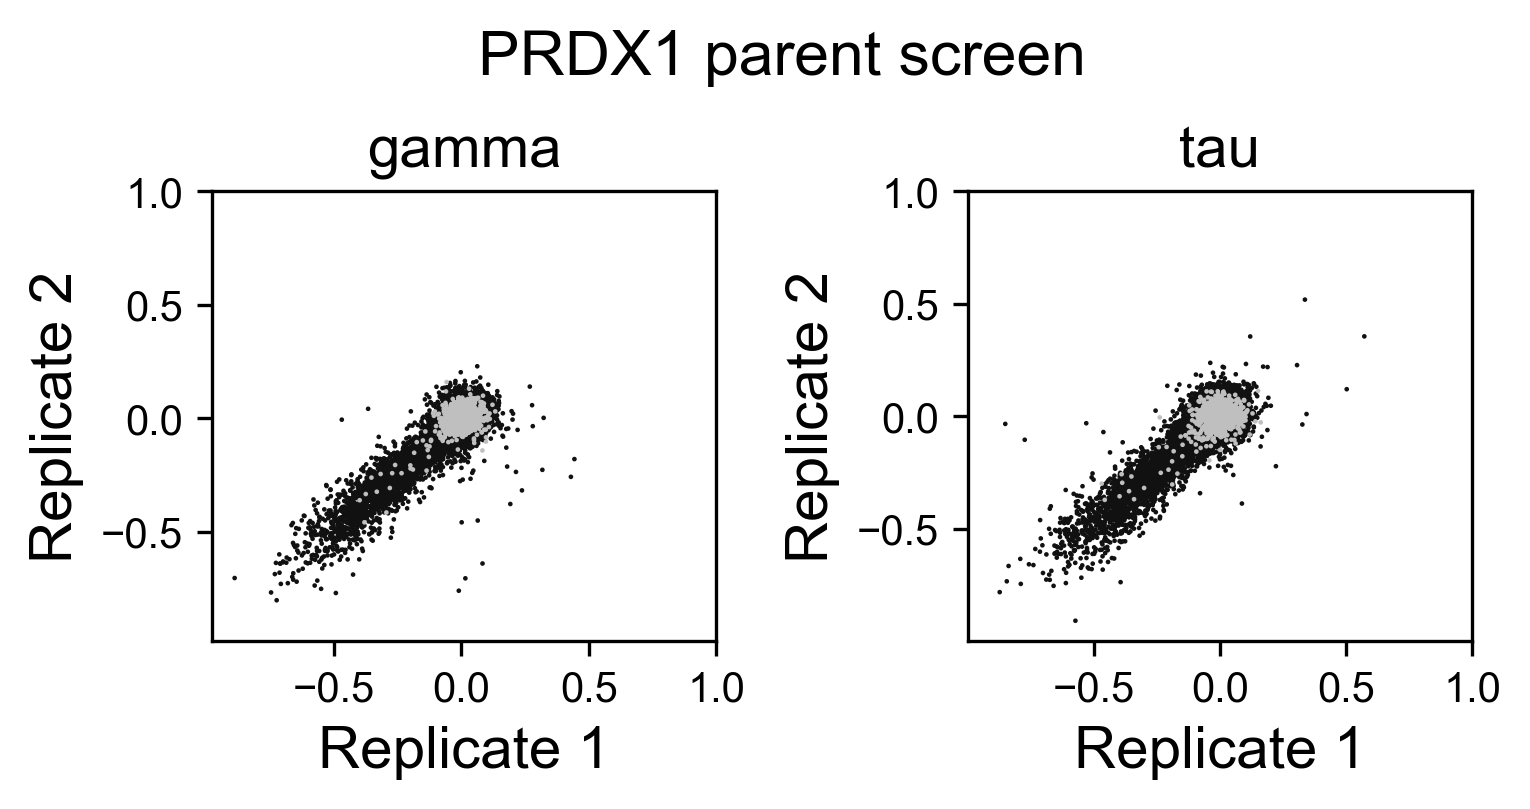

In [341]:
fig, axes = plt.subplots(ncols=2,
                         figsize=(5,3), 
                         gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.8,'bottom':.3}, 
                         # sharey=True
                        )
scp.pl.plotReplicateScatter(axes[0], screen.pdata, 'gamma_replicate_1','gamma_replicate_2','gamma',max_val=1,log_transform=False)
scp.pl.plotReplicateScatter(axes[1], screen.pdata, 'tau_replicate_1','tau_replicate_2','tau',max_val=1,log_transform=False)


fig.suptitle('PRDX1 parent screen',fontsize=15)

# plt.savefig('NAC_counts_qc.pdf',bbox_inches='tight')
plt.show()

### save to file

In [348]:
screen.getAnnotatedTable(threshold=1, ctrl_label='negative_control')

gamma:vehicle_vs_T0            \
                                                             target     score   
A1BG_+_58858964.23-P1|A1BG_-_58858788.23-P1                    A1BG  0.040147   
A1BG_-_58864840.23-P2|A1BG_-_58864822.23-P2                    A1BG  0.030319   
A1CF_+_52645339.23-P1P2|A1CF_-_52645373.23-P1P2                A1CF -0.018767   
A2M_+_9268487.23-P1P2|A2M_+_9268495.23-P1P2                     A2M -0.008484   
A2ML1_+_8975211.23-P1P2|A2ML1_-_8975593.23-P1P2               A2ML1 -0.022863   
...                                                             ...       ...   
non-targeting_03774|non-targeting_00475            negative_control -0.008755   
non-targeting_03778|non-targeting_00397            negative_control  0.009254   
non-targeting_03783|non-targeting_02098            negative_control -0.020390   
non-targeting_03785|non-targeting_00377            negative_control -0.055354   
non-targeting_03787|non-targeting_00777            negative_control  0.023005   

                                                                            \
                                                ttest pvalue BH adj_pvalue   
A1BG_+_58858964.23-P1|A1BG_-_58858788.23-P1         0.119252      0.301808   
A1BG_-_58864840.23-P2|A1BG_-_58864822.23-P2         0.411187      0.599766   
A1CF_+_52645339.23-P1P2|A1CF_-_52645373.23-P1P2     0.623642      0.761137   
A2M_+_9268487.23-P1P2|A2M_+_9268495.23-P1P2         0.987917      0.992632   
A2ML1_+_8975211.23-P1P2|A2ML1_-_8975593.23-P1P2     0.222890      0.425279   
...                                                      ...           ...   
non-targeting_03774|non-targeting_00475             0.945086      0.965995   
non-targeting_03778|non-targeting_00397             0.379003      0.570632   
non-targeting_03783|non-targeting_02098             0.724322      0.830012   
non-targeting_03785|non-targeting_00377             0.156728      0.350983   
non-targeting_03787|non-targeting_00777             0.119763      0.302567   

                                                                   \
                                                gamma_replicate_1   
A1BG_+_58858964.23-P1|A1BG_-_58858788.23-P1              0.066677   
A1BG_-_58864840.23-P2|A1BG_-_58864822.23-P2              0.054331   
A1CF_+_52645339.23-P1P2|A1CF_-_52645373.23-P1P2         -0.043168   
A2M_+_9268487.23-P1P2|A2M_+_9268495.23-P1P2             -0.045406   
A2ML1_+_8975211.23-P1P2|A2ML1_-_8975593.23-P1P2         -0.008546   
...                                                           ...   
non-targeting_03774|non-targeting_00475                 -0.058326   
non-targeting_03778|non-targeting_00397                 -0.000579   
non-targeting_03783|non-targeting_02098                  0.006841   
non-targeting_03785|non-targeting_00377                 -0.083613   
non-targeting_03787|non-targeting_00777                 -0.001062   

                                                                   \
                                                gamma_replicate_2   
A1BG_+_58858964.23-P1|A1BG_-_58858788.23-P1              0.043184   
A1BG_-_58864840.23-P2|A1BG_-_58864822.23-P2             -0.052274   
A1CF_+_52645339.23-P1P2|A1CF_-_52645373.23-P1P2         -0.016640   
A2M_+_9268487.23-P1P2|A2M_+_9268495.23-P1P2              0.020591   
A2ML1_+_8975211.23-P1P2|A2ML1_-_8975593.23-P1P2         -0.030866   
...                                                           ...   
non-targeting_03774|non-targeting_00475                  0.043672   
non-targeting_03778|non-targeting_00397                 -0.014924   
non-targeting_03783|non-targeting_02098                 -0.062102   
non-targeting_03785|non-targeting_00377                 -0.017846   
non-targeting_03787|non-targeting_00777                  0.031827   

                                                                   \
                                                gamma_replicate_3   
A1BG_+_58858964.23-P1|A1BG_-_58858788.23-P1  

In [349]:
# ann_score_table(screen).to_excel('results/PRDX1_parent_screen.xlsx')

### PRDX1 KO screen

In [362]:
screen = scp.PooledScreens(adata_PRDX1KO)

scp.utils.find_low_counts(screen.adata)

screen.adata = screen.adata[:,~screen.adata.var.low_count].copy()

screen.countNormalization()

43922 variables with less than 50 reads (filter_type: 'either')


In [363]:
screen.adata.obs

,cell line,timepoint,condition,replicate,pop doublings,pop_doublings,size_factors
i09,PRDX1KO,T0,T0,1,-,NaN,0.773745
i10,PRDX1KO,T0,T0,2,-,NaN,0.718691
i11,PRDX1KO,Tend,vehicle,1,6.93964,6.939640,1.124081
i12,PRDX1KO,Tend,vehicle,2,7.325594,7.325594,1.143782
i13,PRDX1KO,Tend,vehicle,3,7.048209,7.048209,2.507439
i14,PRDX1KO,Tend,DNAPKi,1,1.94945,1.949450,0.861081
i15,PRDX1KO,Tend,DNAPKi,2,2.113679,2.113679,0.890575
i16,PRDX1KO,Tend,DNAPKi,3,2.469331,2.469331,1.015226
i09_i10,PRDX1KO,T0,T0,3,-,NaN,0.740194


In [364]:
screen.calculateDrugScreen(
    t0='T0', untreated='vehicle', treated='DNAPKi',
    db_untreated = 7.1,
    db_treated = 2.1,
    score_level='compare_reps'
)

	vehicle vs T0
	DNAPKi vs T0
	DNAPKi vs vehicle


In [365]:
gamma = screen.phenotypes['compare_reps']['gamma:vehicle_vs_T0'].iloc[:,:3].reset_index(drop=True)

tau = screen.phenotypes['compare_reps']['tau:DNAPKi_vs_T0'].iloc[:,:3].reset_index(drop=True)

rho = screen.phenotypes['compare_reps']['rho:DNAPKi_vs_vehicle'].iloc[:,:3].reset_index(drop=True)

In [366]:
gamma.score.min(),gamma.score.max(), max(-np.log10(gamma['ttest pvalue']))

(-1.0227890750290363, 0.2299121911802905, 5.786452033238679)

In [367]:
tau.score.min(),tau.score.max(),max(-np.log10(tau['ttest pvalue']))

(-2.027804747826891, 1.2769733469099398, 5.318473967749246)

In [368]:
rho.score.min(),rho.score.max(),max(-np.log10(rho['ttest pvalue']))

(-0.3987777461622809, 0.8886204661486202, 5.569316019640717)

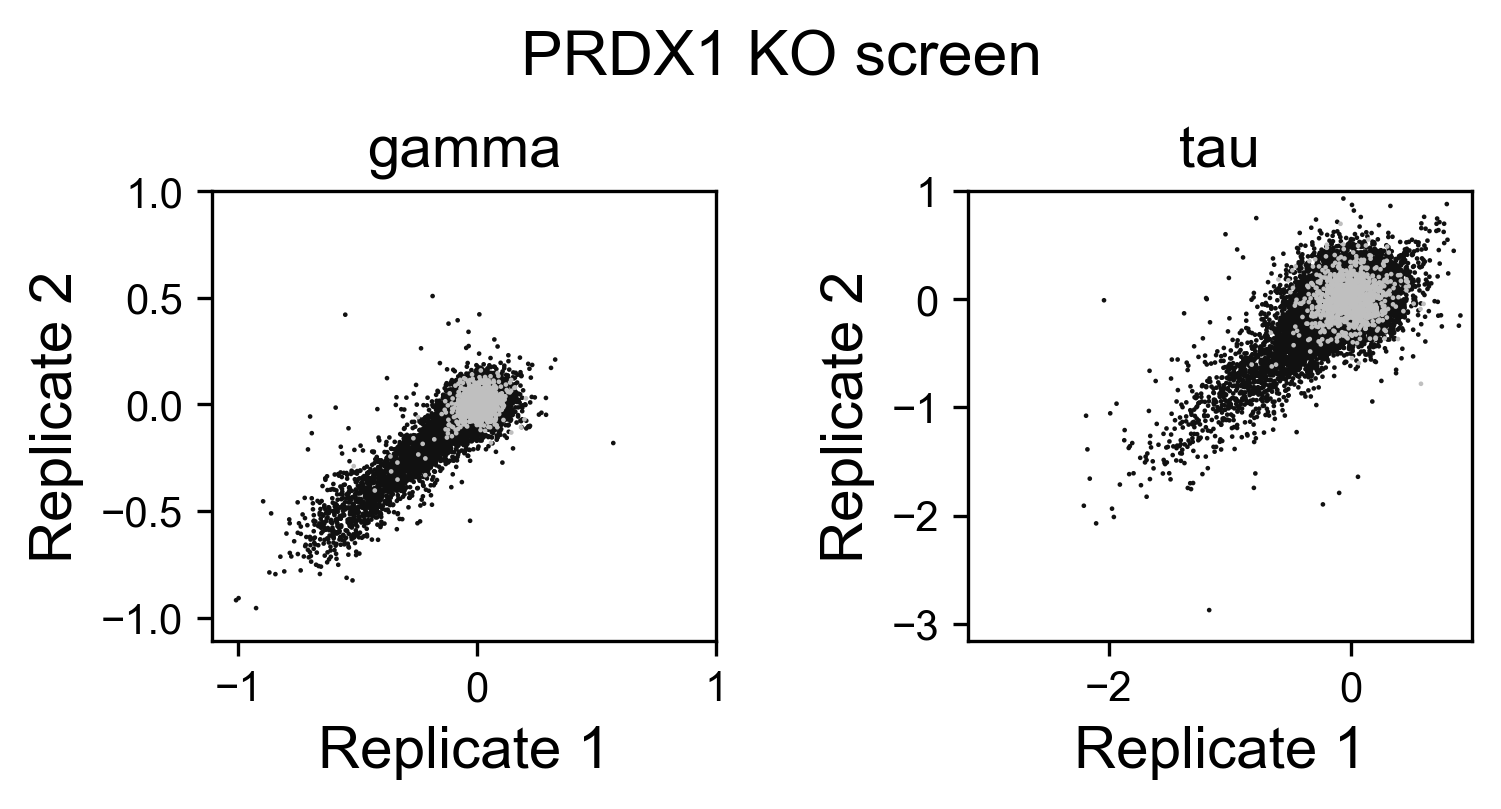

In [370]:
fig, axes = plt.subplots(ncols=2,
                         figsize=(5,3), 
                         gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.8,'bottom':.3}, 
                         # sharey=True
                        )
scp.pl.plotReplicateScatter(axes[0], screen.pdata, 'gamma_replicate_1','gamma_replicate_2','gamma',max_val=1,log_transform=False)
scp.pl.plotReplicateScatter(axes[1], screen.pdata, 'tau_replicate_1','tau_replicate_2','tau',max_val=1,log_transform=False)


fig.suptitle('PRDX1 KO screen',fontsize=15)

# plt.savefig('NAC_counts_qc.pdf',bbox_inches='tight')
plt.show()

### save to file

In [372]:
screen.adata.obs

,cell line,timepoint,condition,replicate,pop doublings,pop_doublings,size_factors
i09,PRDX1KO,T0,T0,1,-,NaN,0.773745
i10,PRDX1KO,T0,T0,2,-,NaN,0.718691
i11,PRDX1KO,Tend,vehicle,1,6.93964,6.939640,1.124081
i12,PRDX1KO,Tend,vehicle,2,7.325594,7.325594,1.143782
i13,PRDX1KO,Tend,vehicle,3,7.048209,7.048209,2.507439
i14,PRDX1KO,Tend,DNAPKi,1,1.94945,1.949450,0.861081
i15,PRDX1KO,Tend,DNAPKi,2,2.113679,2.113679,0.890575
i16,PRDX1KO,Tend,DNAPKi,3,2.469331,2.469331,1.015226
i09_i10,PRDX1KO,T0,T0,3,-,NaN,0.740194


In [371]:
screen.getAnnotatedTable(threshold=1, ctrl_label='negative_control')

gamma:vehicle_vs_T0            \
                                                             target     score   
A1BG_+_58858964.23-P1|A1BG_-_58858788.23-P1                    A1BG  0.038506   
A1BG_-_58864840.23-P2|A1BG_-_58864822.23-P2                    A1BG -0.023462   
A1CF_+_52645339.23-P1P2|A1CF_-_52645373.23-P1P2                A1CF -0.016855   
A2M_+_9268487.23-P1P2|A2M_+_9268495.23-P1P2                     A2M  0.041671   
A2ML1_+_8975211.23-P1P2|A2ML1_-_8975593.23-P1P2               A2ML1 -0.040506   
...                                                             ...       ...   
non-targeting_03774|non-targeting_00475            negative_control -0.023903   
non-targeting_03778|non-targeting_00397            negative_control -0.019576   
non-targeting_03783|non-targeting_02098            negative_control  0.031542   
non-targeting_03785|non-targeting_00377            negative_control -0.213475   
non-targeting_03787|non-targeting_00777            negative_control  0.101246   

                                                                            \
                                                ttest pvalue BH adj_pvalue   
A1BG_+_58858964.23-P1|A1BG_-_58858788.23-P1         0.034589      0.158038   
A1BG_-_58864840.23-P2|A1BG_-_58864822.23-P2         0.902664      0.944022   
A1CF_+_52645339.23-P1P2|A1CF_-_52645373.23-P1P2     0.972022      0.984820   
A2M_+_9268487.23-P1P2|A2M_+_9268495.23-P1P2         0.126355      0.309175   
A2ML1_+_8975211.23-P1P2|A2ML1_-_8975593.23-P1P2     0.137930      0.323674   
...                                                      ...           ...   
non-targeting_03774|non-targeting_00475             0.648949      0.774649   
non-targeting_03778|non-targeting_00397             0.885029      0.932443   
non-targeting_03783|non-targeting_02098             0.254301      0.448448   
non-targeting_03785|non-targeting_00377             0.013121      0.098215   
non-targeting_03787|non-targeting_00777             0.052646      0.193916   

                                                                   \
                                                gamma_replicate_1   
A1BG_+_58858964.23-P1|A1BG_-_58858788.23-P1              0.025233   
A1BG_-_58864840.23-P2|A1BG_-_58864822.23-P2             -0.059772   
A1CF_+_52645339.23-P1P2|A1CF_-_52645373.23-P1P2         -0.010705   
A2M_+_9268487.23-P1P2|A2M_+_9268495.23-P1P2              0.061493   
A2ML1_+_8975211.23-P1P2|A2ML1_-_8975593.23-P1P2         -0.022732   
...                                                           ...   
non-targeting_03774|non-targeting_00475                 -0.007012   
non-targeting_03778|non-targeting_00397                  0.028370   
non-targeting_03783|non-targeting_02098                  0.086302   
non-targeting_03785|non-targeting_00377                 -0.217019   
non-targeting_03787|non-targeting_00777                  0.055885   

                                                                   \
                                                gamma_replicate_2   
A1BG_+_58858964.23-P1|A1BG_-_58858788.23-P1              0.039791   
A1BG_-_58864840.23-P2|A1BG_-_58864822.23-P2             -0.033558   
A1CF_+_52645339.23-P1P2|A1CF_-_52645373.23-P1P2         -0.010421   
A2M_+_9268487.23-P1P2|A2M_+_9268495.23-P1P2             -0.000996   
A2ML1_+_8975211.23-P1P2|A2ML1_-_8975593.23-P1P2         -0.036212   
...                                                           ...   
non-targeting_03774|non-targeting_00475                 -0.012105   
non-targeting_03778|non-targeting_00397                 -0.058419   
non-targeting_03783|non-targeting_02098                  0.013256   
non-targeting_03785|non-targeting_00377                 -0.253599   
non-targeting_03787|non-targeting_00777                  0.131816   

                                                                   \
                                                gamma_replicate_3   
A1BG_+_58858964.23-P1|A1BG_-_58858788.23-P1  

In [ ]:
# ann_score_table(screen).to_excel('results/PRDX1_KO_screen.xlsx')

# 

In [373]:
%reload_ext watermark

In [374]:
%watermark

Last updated: 2024-07-10T03:03:38.919033-07:00

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.15.0-107-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit



In [375]:
%watermark --iversions

numpy     : 1.26.4
scanpy    : 1.9.6
pandas    : 2.1.4
anndata   : 0.10.7
screenpro : 0.4.0
matplotlib: 3.6.3



In [376]:
!date

Wed Jul 10 03:03:46 AM PDT 2024
